# Micro-Doppler Effect of a Rotating Object with a Doppler Radar

This is an example of using `RadarSimPy` to simulate the micro-Doppler effect of a rotating plate with
a Doppler radar. Ray-Tracing/Shoot-and-Bounce-Rays method is used in `RadarSimPy`. The ray-tracing engine `RadarSimC`, which is built with C++, is integrated in RadarSimPy.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**

This notebook is available on my <a href="https://github.com/rookiepeng/radar-simulation-notebooks" target="_blank">GitHub</a>.

---

## Radar Model
### Transmitter

The following table lists the basic parameters of the radar transmitter.

| Parameter                       | Variable in `RadarSimPy` | Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | fc                       | 24.125 GHz |
| Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
| Signal length ($T$)             | pulse_length             | 2 s        |

### Receiver
The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in `RadarSimPy` | Value        |
|----------------------------------|--------------------------|--------------|
| Sampling rate ($f_s$)            | fs                       | 400 sps      |
| Noise figure ($NF$)               | noise_figure              | 20 dB        |
| RF gain/loss ($G_{rf}$)          | rf_gain                  | 20 dB        |
| Baseband gain ($G_{BB}$)         | baseband_gain            | 50 dB        |
| Load resistor ($R_L$)            | load_resistor            | 1000 $\Omega$|

### Aperture
The radar aperture to receive the reflected rays. 

| Parameter   | Physical Meaning                                       |
|-------------|--------------------------------------------------------|
| phi         | Angle phi of the aperture normal (degree)              |
| theta       | Angle theta of the aperture normal (degree)            |
| location    | Center location of the aperture (x, y, z) m            |
| extension   | Extension of the aperture (left, right, top, bottom) m |


In [3]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

import matplotlib.pyplot as plt

tx = Transmitter(fc=24.125e9,
                 tx_power=10,
                 pulse_length=2,
                 pulses=1,
                 channels=[dict(location=(0, 0, 0))])

rx = Receiver(fs=400,
              noise_figure=12,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=1000,
              channels=[dict(location=(0, 0, 0))])


radar = Radar(transmitter=tx, receiver=rx)

aperture = dict(
    phi=0,
    theta=90,
    location=[0, 0, 0],
    extension=[0.1, 0.1, 0.1, 0.1]
)

radar = Radar(transmitter=tx, receiver=rx, aperture=aperture)

## Target Model

In [4]:
target_1 = {
    'model': '../models/plate.stl',
    'location': (30, 0, 0),
    'rotation': (0, -20, 0),
    'rotation_rate': (0, 20, 0),
    'speed': (0, 0, 0)
}

targets = [target_1]

## Ray Tracing

In [5]:
from radarsimpy import scene

processed_ray = scene(radar, targets, density=1, level='sample')

## Radar Baseband Data

In [6]:
import radarsimpy.simulator as sim

data = sim.run_simulator(radar, processed_ray, is_raytracing=True, correction=-42)
timestamp = data['timestamp']
baseband = data['baseband']

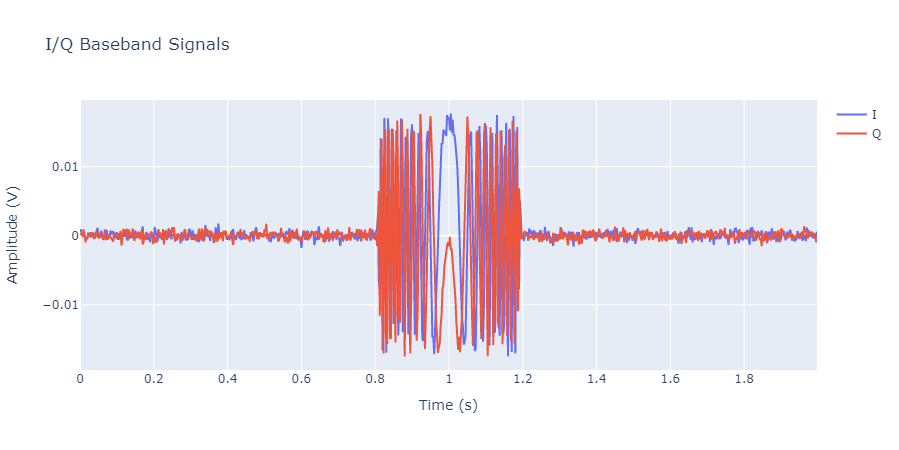

In [7]:
from plotly.offline import iplot
import plotly.graph_objs as go

beat_I = go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
)
beat_Q = go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
)
data = [beat_I, beat_Q]

layout = go.Layout(
    title='I/Q Baseband Signals',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

fig = go.Figure(data, layout=layout)
iplot(fig)

## Short-Time Fourier Transform

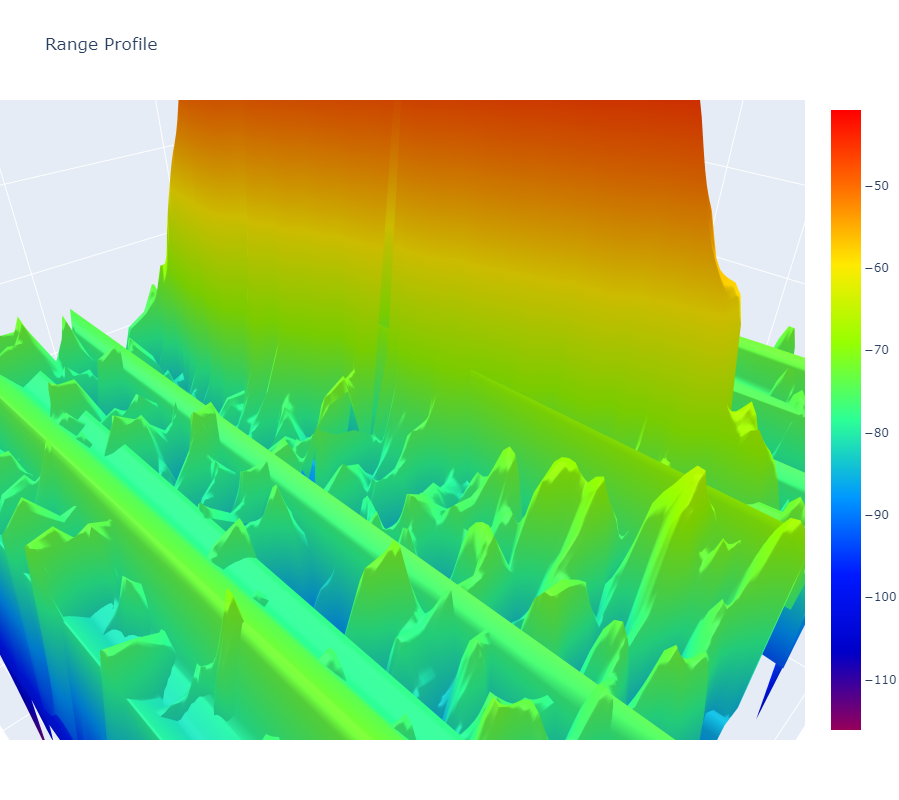

In [8]:
import plotly.graph_objs as go
from plotly.offline import iplot

from scipy.signal import stft
np.shape(baseband)

spec = stft(baseband[0,0,:], fs=radar.receiver.fs, nperseg=64, noverlap=40, nfft=128,return_onesided=False)


data = [go.Surface(x=spec[1], y=spec[0], z=20*np.log10(np.abs(spec[2])), colorscale='Rainbow')]

layout = go.Layout(
    title='Range Profile',
    height=800,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Chirp'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation='h'),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)